In [1]:
%load_ext autoreload
%autoreload 2

import os
import xarray as xr

from fme_diags.utils import get_run_kwargs, load_config, open_autoregressive_inference
from fme_diags.tropics.tropics import (
    compute_wavenumber_frequency_spectra, 
    plot_wavenumber_frequency_spectra
)

_ = xr.set_options(keep_attrs=True)

In [2]:
if not "RUN_KEY" in os.environ:
    RUN_KEY = "42yrs-batch_size8-max_epochs50-lr3e-4-run4"
else:
    RUN_KEY = os.environ["RUN_KEY"]

In [3]:
config = load_config("./preds.yaml")
run_kwargs = get_run_kwargs(config, RUN_KEY)

LAT_BOUNDS = (-15, 15)

run_kwargs

{'path': '/pscratch/sd/j/jpduncan/ai2/datasets/2023-11-22-e3smv2-vertically-resolved-1deg-fme-dataset/output/42-years-training-set/42yrs-batch_size8-max_epochs50-lr3e-4-run4/autoregressive_predictions.nc',
 'start': '0054-01-01',
 'step_dim': 'lead',
 'step_freq': '6H',
 'calendar': 'noleap',
 'flip_lat': False,
 'chunks': {'lead': 178}}

In [4]:
FIG_PREFIX = "wheeler-kiladis"
OUTDIR = f"figs/{RUN_KEY}"
os.makedirs(OUTDIR, exist_ok=True)

In [5]:
ds = open_autoregressive_inference(**run_kwargs)
ds

<xarray.Dataset>
Dimensions:                                        (time: 14597, sample: 1,
                                                    source: 2, lat: 180,
                                                    lon: 360)
Coordinates:
  * time                                           (time) object 0054-01-01 0...
    init                                           (sample) object dask.array<chunksize=(1,), meta=np.ndarray>
    valid_time                                     (sample, time) object dask.array<chunksize=(1, 178), meta=np.ndarray>
  * source                                         (source) object 'target' '...
  * lat                                            (lat) float32 89.24 ... -8...
  * lon                                            (lon) float32 0.5 ... 359.5
Dimensions without coordinates: sample
Data variables: (12/49)
    surface_upward_shortwave_flux                  (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    specific_total_water_7                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    PHIS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    T_3                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    T_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    U_3                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    ...                                             ...
    V_2                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    V_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    LHFLX                                          (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    TS                                             (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    FSDS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    specific_total_water_4                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>

Compute spectra

In [6]:
%%time

# remove initial condition
da = ds['surface_precipitation_rate'].isel(sample=0, time=slice(1, None))

spectra = compute_wavenumber_frequency_spectra(da, segment_size=128, latitude_bounds=LAT_BOUNDS)
spectra

INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3650, 'lat': 30, 'lon': 360})


[########################################] | 100% Completed | 32.0s
[########################################] | 100% Completed | 35.3s


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0054-05-17 00:00:00 ... 0063-11-16 00:00:00
  * lat         (lat) float32 14.46 13.46 12.47 11.47 ... -12.47 -13.46 -14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0054-05-17 00:00:00 ... 0063-11-16 00:00:00
  * lat         (lat) float32 14.46 13.46 12.47 11.47 ... -12.47 -13.46 -14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).

Metadata for spectral power components is:
('component', 'wavenumber', 'frequency')
Coordinates:
  * wavenumber  (wavenumber) int64 -180 -179 -178 -177 -176 ... 177 178 179 180
  * frequency   (frequency) float64 -0.5 -0.4922 -0.4844 ... 0.4844 0.4922 0.5
  * component   (component) <U13 'total' 'symmetric' 'antisymmetric'
{}

From smoothFrq121:  Frequency smoothing 1 times for subset of wavenumbers (pos frqs only)

Smoothing background spectrum in wavenumber (pos frq only)...
  Wavenumber smoothing 5 times for freq: 0.0078125
  Wavenumber smoothing 5 times for freq: 0.015625
  Wavenumber smoothing 5 times for freq: 0.0234375
  Wavenumber smoothing 5 times for freq: 0.03125
  Wavenumber smoothing 5 times for freq: 0.0390625
  Wavenumber smoothing 5 times for freq: 0.046875
  Wavenumber smoothing 5 times for freq: 0.0546875
  Wavenumber smoothing 5 times for freq: 0.0625
  Wavenumber smoothing 5 times for freq: 0.0703125
  Wavenumber smoothing 5 

INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3650, 'lat': 30, 'lon': 360})


Frequency smoothing 10 times for all wavenumbers (pos frqs only)
[########################################] | 100% Completed | 20.0s
[########################################] | 100% Completed |  7.0s


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0054-05-17 00:00:00 ... 0063-11-16 00:00:00
  * lat         (lat) float32 14.46 13.46 12.47 11.47 ... -12.47 -13.46 -14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0054-05-17 00:00:00 ... 0063-11-16 00:00:00
  * lat         (lat) float32 14.46 13.46 12.47 11.47 ... -12.47 -13.46 -14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).

Metadata for spectral power components is:
('component', 'wavenumber', 'frequency')
Coordinates:
  * wavenumber  (wavenumber) int64 -180 -179 -178 -177 -176 ... 177 178 179 180
  * frequency   (frequency) float64 -0.5 -0.4922 -0.4844 ... 0.4844 0.4922 0.5
  * component   (component) <U13 'total' 'symmetric' 'antisymmetric'
{}

From smoothFrq121:  Frequency smoothing 1 times for subset of wavenumbers (pos frqs only)

Smoothing background spectrum in wavenumber (pos frq only)...
  Wavenumber smoothing 5 times for freq: 0.0078125
  Wavenumber smoothing 5 times for freq: 0.015625
  Wavenumber smoothing 5 times for freq: 0.0234375
  Wavenumber smoothing 5 times for freq: 0.03125
  Wavenumber smoothing 5 times for freq: 0.0390625
  Wavenumber smoothing 5 times for freq: 0.046875
  Wavenumber smoothing 5 times for freq: 0.0546875
  Wavenumber smoothing 5 times for freq: 0.0625
  Wavenumber smoothing 5 times for freq: 0.0703125
  Wavenumber smoothing 5 

<xarray.Dataset>
Dimensions:     (wavenumber: 361, frequency: 129, component: 4, source: 2)
Coordinates:
  * wavenumber  (wavenumber) int64 -180 -179 -178 -177 -176 ... 177 178 179 180
  * frequency   (frequency) float64 -0.5 -0.4922 -0.4844 ... 0.4844 0.4922 0.5
  * component   (component) <U13 'total' 'symmetric' ... 'background'
    init        object dask.array<chunksize=(), meta=np.ndarray>
  * source      (source) <U10 'target' 'prediction'
Data variables:
    spectrum    (source, component, wavenumber, frequency) float64 0.0 ... 1....

Plot normalized symmetric spectra.

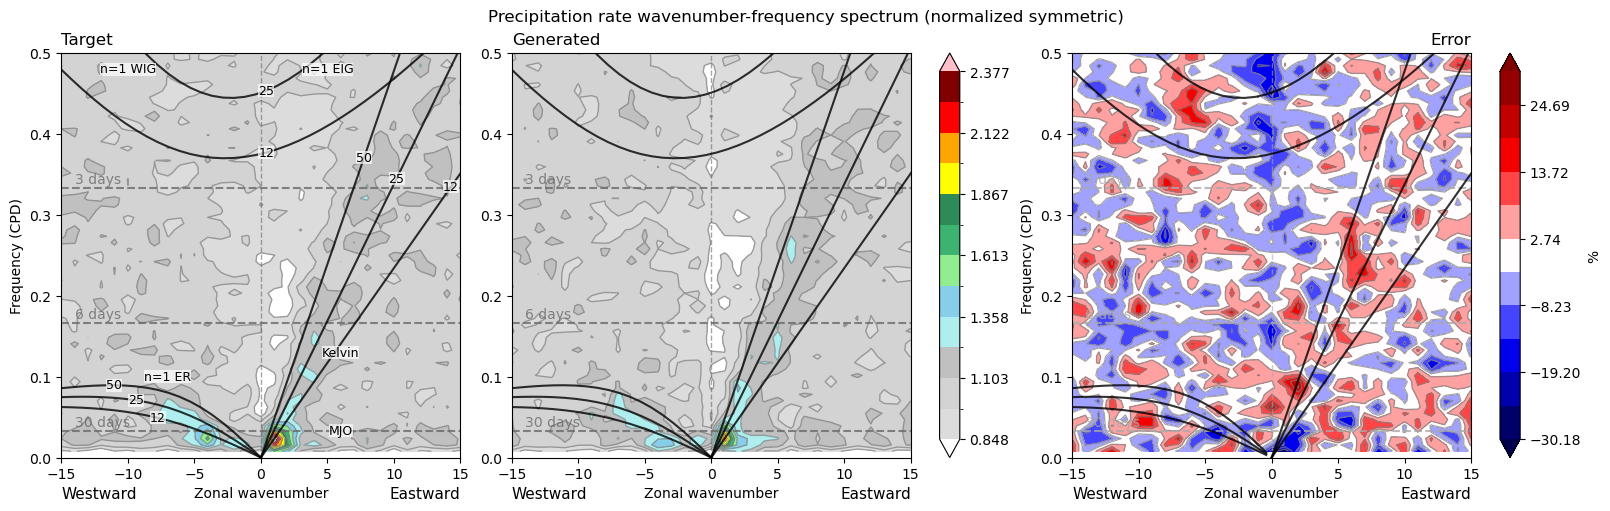

In [7]:
fig, axs = plot_wavenumber_frequency_spectra(spectra, component="symmetric")

In [8]:
fig.savefig(os.path.join(OUTDIR, f"{FIG_PREFIX}_fig1.png"), bbox_inches="tight")

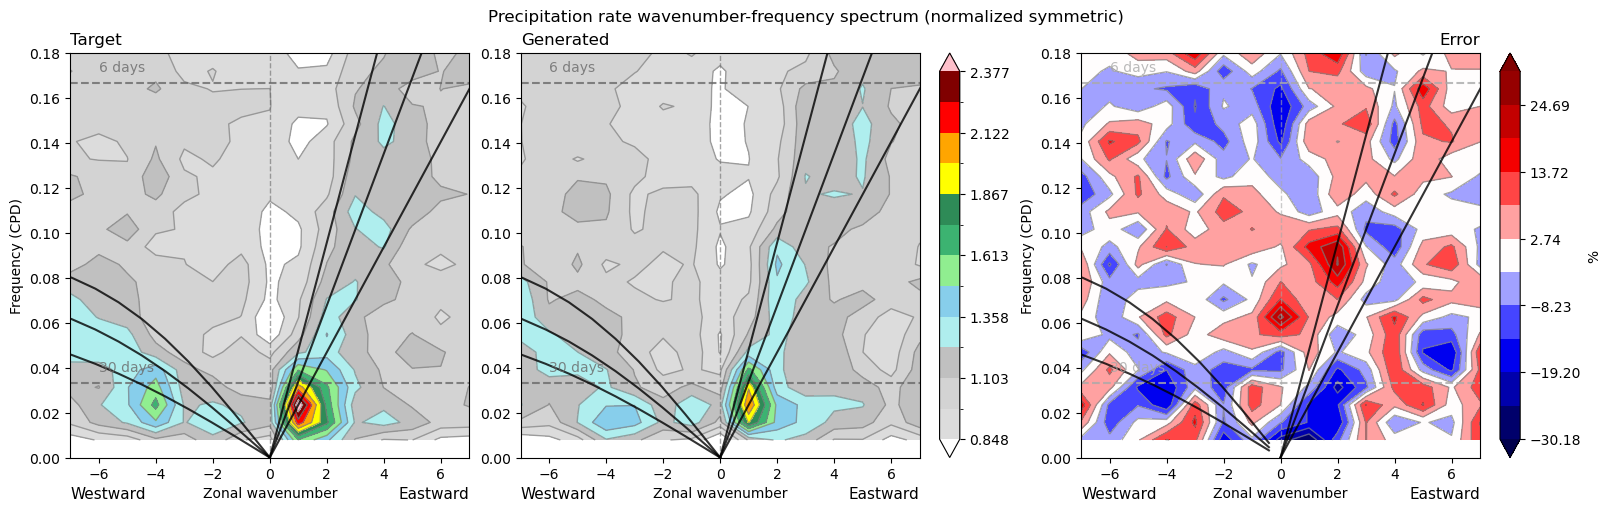

In [9]:
fig, axs = plot_wavenumber_frequency_spectra(spectra, component="symmetric", mjo_zoom=True)

In [10]:
fig.savefig(os.path.join(OUTDIR, f"{FIG_PREFIX}_fig2.png"), bbox_inches="tight")